In [63]:
# imports
# these two lines for Kamil becouse it does not seem to work at all!
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from gensim.models import Word2Vec
import wordcloud
%matplotlib inline

In [64]:
sys.path.append('c:/users/msims/appdata/roaming/python/python39/site-packages')

# 1) Preparing the dataset

In [35]:
# load data
data_source = 'data/realdonaldtrump.csv'
df = pd.read_csv(data_source)
column_names = df.head(0).columns # column names
print(column_names)

Index(['id', 'link', 'content', 'date', 'retweets', 'favorites', 'mentions',
       'hashtags'],
      dtype='object')


In [36]:
print(pd.isnull(df).sum()) # empty cells in each column

id               0
link             0
content          0
date             0
retweets         0
favorites        0
mentions     22966
hashtags     37769
dtype: int64


In [37]:
print(df.shape) # number of rows and columns

(43352, 8)


In [38]:
print(df.dtypes) # column types

id            int64
link         object
content      object
date         object
retweets      int64
favorites     int64
mentions     object
hashtags     object
dtype: object


In [39]:
print(df.head()) # first 5 rows

           id                                               link  \
0  1698308935  https://twitter.com/realDonaldTrump/status/169...   
1  1701461182  https://twitter.com/realDonaldTrump/status/170...   
2  1737479987  https://twitter.com/realDonaldTrump/status/173...   
3  1741160716  https://twitter.com/realDonaldTrump/status/174...   
4  1773561338  https://twitter.com/realDonaldTrump/status/177...   

                                             content                 date  \
0  Be sure to tune in and watch Donald Trump on L...  2009-05-04 13:54:25   
1  Donald Trump will be appearing on The View tom...  2009-05-04 20:00:10   
2  Donald Trump reads Top Ten Financial Tips on L...  2009-05-08 08:38:08   
3  New Blog Post: Celebrity Apprentice Finale and...  2009-05-08 15:40:15   
4  "My persona will never be that of a wallflower...  2009-05-12 09:07:28   

   retweets  favorites mentions hashtags  
0       510        917      NaN      NaN  
1        34        267      NaN      NaN  

# 2) Visualize dataset

In [40]:
plt.rcParams["figure.figsize"] = (10, 10) 

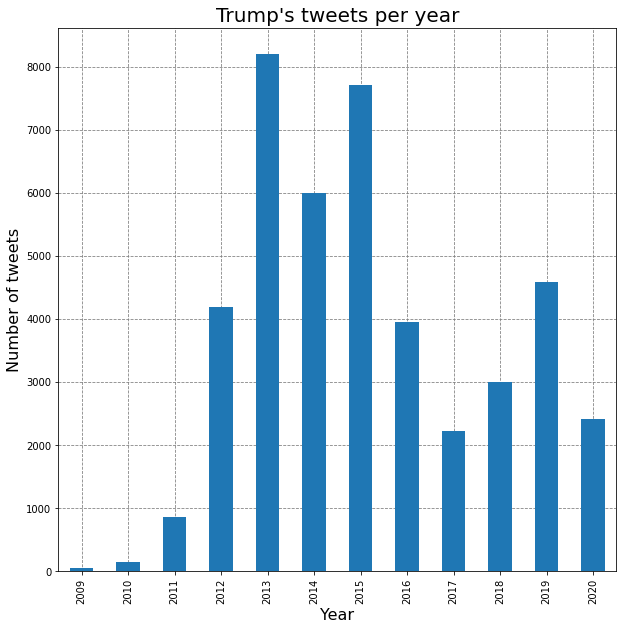

In [41]:
df['date'] = df['date'].astype('datetime64')
ax = df.groupby([df['date'].dt.year])['id'].count().plot(kind='bar')

ax.set_title('Trump\'s tweets per year', fontsize=20)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Number of tweets', fontsize=16)

ax.set_axisbelow(True)
ax.grid(color='gray', linestyle='dashed')

# 3) 

In [42]:
positive_words_filepath = 'data/positive-words.txt'
negative_words_filepath = 'data/negative-words.txt'

# lists containing positive and negative words
positive_words = np.loadtxt(positive_words_filepath, dtype='str', comments=';', delimiter='\n') 
negative_words = np.loadtxt(negative_words_filepath, dtype='str', comments=';', delimiter='\n')

print(positive_words)
print(negative_words)

['a+' 'abound' 'abounds' ... 'zenith' 'zest' 'zippy']
['2-faced' '2-faces' 'abnormal' ... 'zealous' 'zealously' 'zombie']


In [43]:
df['content'] = df['content'].astype(str)  # getting the context of tweet to analysis
df.head(3)

,id,link,content,date,retweets,favorites,mentions,hashtags
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN


In [44]:
#Tokenization
reqexp = nltk.tokenize.RegexpTokenizer('\w+')
df['text_token'] = df['content'].str.lower().apply(reqexp.tokenize)
df.head(3)

,id,link,content,date,retweets,favorites,mentions,hashtags,text_token
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN,"[be, sure, to, tune, in, and, watch, donald, t..."
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN,"[donald, trump, will, be, appearing, on, the, ..."
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN,"[donald, trump, reads, top, ten, financial, ti..."


In [45]:
#Remove stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")
df['text_token'] = df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
df.head(3)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\michu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,id,link,content,date,retweets,favorites,mentions,hashtags,text_token
0,1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN,"[sure, tune, watch, donald, trump, late, night..."
1,1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN,"[donald, trump, appearing, view, tomorrow, mor..."
2,1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN,"[donald, trump, reads, top, ten, financial, ti..."


In [46]:
#Remove short words
df['text_string'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
df[['content', 'text_token', 'text_string']].head(3)

,content,text_token,text_string
0,Be sure to tune in and watch Donald Trump on L...,"[sure, tune, watch, donald, trump, late, night...",sure tune watch donald trump late night david ...
1,Donald Trump will be appearing on The View tom...,"[donald, trump, appearing, view, tomorrow, mor...",donald trump appearing view tomorrow morning d...
2,Donald Trump reads Top Ten Financial Tips on L...,"[donald, trump, reads, top, ten, financial, ti...",donald trump reads top ten financial tips late...


In [47]:
all_words = ' '.join([word for word in df['text_string']])
tokenized_words = nltk.tokenize.word_tokenize(all_words)
fdict = nltk.probability.FreqDist(tokenized_words)
fdict

FreqDist({'realdonaldtrump': 8788, 'com': 8318, 'great': 6774, 'trump': 6493, 'twitter': 5669, 'http': 4933, 'thank': 3060, 'president': 3053, 'https': 2928, 'people': 2740, ...})

In [48]:
#Remove infrequent words
df['text_string_fdist'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if fdict[item] >= 3 ]))
df[['content', 'text_token', 'text_string', 'text_string_fdist']].head(3)

,content,text_token,text_string,text_string_fdist
0,Be sure to tune in and watch Donald Trump on L...,"[sure, tune, watch, donald, trump, late, night...",sure tune watch donald trump late night david ...,sure tune watch donald trump late night david ...
1,Donald Trump will be appearing on The View tom...,"[donald, trump, appearing, view, tomorrow, mor...",donald trump appearing view tomorrow morning d...,donald trump appearing view tomorrow morning d...
2,Donald Trump reads Top Ten Financial Tips on L...,"[donald, trump, reads, top, ten, financial, ti...",donald trump reads top ten financial tips late...,donald trump reads top ten financial tips late...


In [49]:
#Lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\michu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\michu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [50]:
wordnet_lem = nltk.stem.WordNetLemmatizer()
df['text_string_lem'] = df['text_string_fdist'].apply(wordnet_lem.lemmatize)
df[['content', 'text_token', 'text_string', 'text_string_fdist', 'text_string_lem']].head(3)

,content,text_token,text_string,text_string_fdist,text_string_lem
0,Be sure to tune in and watch Donald Trump on L...,"[sure, tune, watch, donald, trump, late, night...",sure tune watch donald trump late night david ...,sure tune watch donald trump late night david ...,sure tune watch donald trump late night david ...
1,Donald Trump will be appearing on The View tom...,"[donald, trump, appearing, view, tomorrow, mor...",donald trump appearing view tomorrow morning d...,donald trump appearing view tomorrow morning d...,donald trump appearing view tomorrow morning d...
2,Donald Trump reads Top Ten Financial Tips on L...,"[donald, trump, reads, top, ten, financial, ti...",donald trump reads top ten financial tips late...,donald trump reads top ten financial tips late...,donald trump reads top ten financial tips late...


In [51]:
df['is_equal']= (df['text_string_fdist']==df['text_string_lem'])
df.is_equal.value_counts()

True     43345
False        7
Name: is_equal, dtype: int64

(-0.5, 599.5, 399.5, -0.5)

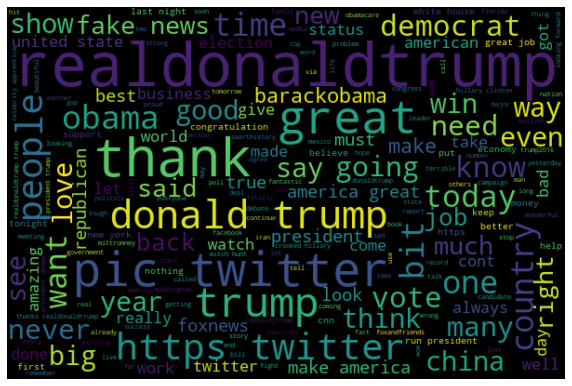

In [52]:
#Word cloud
all_words_lem = ' '.join([word for word in df['text_string_lem']])
wordcloud = wordcloud.WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words_lem)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

In [66]:
#Sentiment analysis
nltk.download('vader_lexicon') # mostly used for social media

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\michu\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [67]:
from nltk.sentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [68]:
df['polarity'] = df['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x)) # Vader lexicon uses some of the stopwords we removed!!!
df.head(3)

,content,date,text_token,text_string,text_string_fdist,text_string_lem,is_equal,neg,neu,pos,compound,sentiment,polarity
0,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,"[sure, tune, watch, donald, trump, late, night...",sure tune watch donald trump late night david ...,sure tune watch donald trump late night david ...,sure tune watch donald trump late night david ...,True,0.0,0.745,0.255,0.4767,positive,"{'neg': 0.0, 'neu': 0.745, 'pos': 0.255, 'comp..."
1,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,"[donald, trump, appearing, view, tomorrow, mor...",donald trump appearing view tomorrow morning d...,donald trump appearing view tomorrow morning d...,donald trump appearing view tomorrow morning d...,True,0.0,0.652,0.348,0.7506,positive,"{'neg': 0.0, 'neu': 0.652, 'pos': 0.348, 'comp..."
2,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,"[donald, trump, reads, top, ten, financial, ti...",donald trump reads top ten financial tips late...,donald trump reads top ten financial tips late...,donald trump reads top ten financial tips late...,True,0.0,0.734,0.266,0.5719,positive,"{'neg': 0.0, 'neu': 0.734, 'pos': 0.266, 'comp..."


In [69]:
df = pd.concat(
    [df.drop(['id', 'link', 'polarity', 'mentions', 'hashtags', 'retweets', 'favorites'], axis=1), 
     df['polarity'].apply(pd.Series)], axis=1)
df.head(3)

KeyError: "['id', 'link', 'mentions', 'hashtags', 'retweets', 'favorites'] not found in axis"

In [70]:
df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x > 0 else 'neutral' if x==0 else 'negative')
df.head(4)

,content,date,text_token,text_string,text_string_fdist,text_string_lem,is_equal,neg,neu,pos,compound,sentiment,polarity
0,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,"[sure, tune, watch, donald, trump, late, night...",sure tune watch donald trump late night david ...,sure tune watch donald trump late night david ...,sure tune watch donald trump late night david ...,True,0.0,0.745,0.255,0.4767,positive,"{'neg': 0.0, 'neu': 0.745, 'pos': 0.255, 'comp..."
1,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,"[donald, trump, appearing, view, tomorrow, mor...",donald trump appearing view tomorrow morning d...,donald trump appearing view tomorrow morning d...,donald trump appearing view tomorrow morning d...,True,0.0,0.652,0.348,0.7506,positive,"{'neg': 0.0, 'neu': 0.652, 'pos': 0.348, 'comp..."
2,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,"[donald, trump, reads, top, ten, financial, ti...",donald trump reads top ten financial tips late...,donald trump reads top ten financial tips late...,donald trump reads top ten financial tips late...,True,0.0,0.734,0.266,0.5719,positive,"{'neg': 0.0, 'neu': 0.734, 'pos': 0.266, 'comp..."
3,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,"[new, blog, post, celebrity, apprentice, final...",new blog post celebrity apprentice finale less...,new blog post celebrity apprentice finale less...,new blog post celebrity apprentice finale less...,True,0.0,1.000,0.000,0.0000,neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


# 4) Analyze data

In [79]:
# Tweet with highest sentiment
df.loc[df['compound'].idxmax()].values

array(['Congratulations to Patrick Reed on his great and courageous MASTERS win! When Patrick had his amazing win at Doral 5 years ago, people saw his great talent, and a bright future ahead. Now he is the Masters Champion!',
       Timestamp('2018-04-08 19:43:27'),
       list(['congratulations', 'patrick', 'reed', 'great', 'courageous', 'masters', 'win', 'patrick', 'amazing', 'win', 'doral', '5', 'years', 'ago', 'people', 'saw', 'great', 'talent', 'bright', 'future', 'ahead', 'masters', 'champion']),
       'congratulations patrick reed great courageous masters win patrick amazing win doral years ago people saw great talent bright future ahead masters champion',
       'congratulations patrick reed great courageous masters win patrick amazing win doral years ago people saw great talent bright future ahead masters champion',
       'congratulations patrick reed great courageous masters win patrick amazing win doral years ago people saw great talent bright future ahead masters champion

In [80]:
# Tweet with lowest
df.loc[df['compound'].idxmin()].values

array(['Colin Powell was a pathetic interview today on Fake News CNN. In his time, he was weak & gave away everything to everybody - so bad for the USA. Also got the “weapons of mass destruction” totally wrong, and you know what that mistake cost us? Sad! Only negative questions asked.',
       Timestamp('2020-06-07 22:42:18'),
       list(['colin', 'powell', 'pathetic', 'interview', 'today', 'fake', 'news', 'cnn', 'time', 'weak', 'gave', 'away', 'everything', 'everybody', 'bad', 'usa', 'also', 'got', 'weapons', 'mass', 'destruction', 'totally', 'wrong', 'know', 'mistake', 'cost', 'us', 'sad', 'negative', 'questions', 'asked']),
       'colin powell pathetic interview today fake news cnn time weak gave away everything everybody bad usa also got weapons mass destruction totally wrong know mistake cost sad negative questions asked',
       'colin powell pathetic interview today fake news cnn time weak gave away everything everybody bad usa also got weapons mass destruction totally wrong 

Text(0.5, 1.0, 'Number of tweets by sentiment')

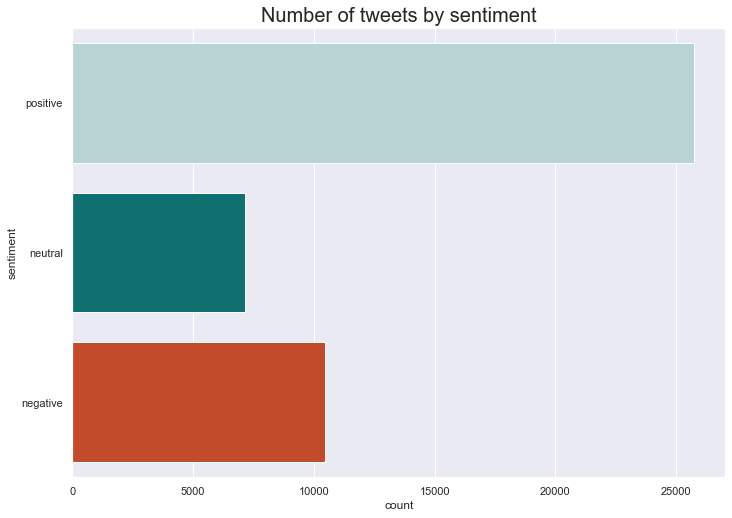

In [85]:
#Visualize data

sns.set(rc={'figure.figsize':(11.7,8.27)})

# Number of tweets 
sns.countplot(y='sentiment', 
             data=df, 
             palette=['#b2d8d8',"#008080", '#db3d13']
             ).set_title('Number of tweets by sentiment', fontsize=20)

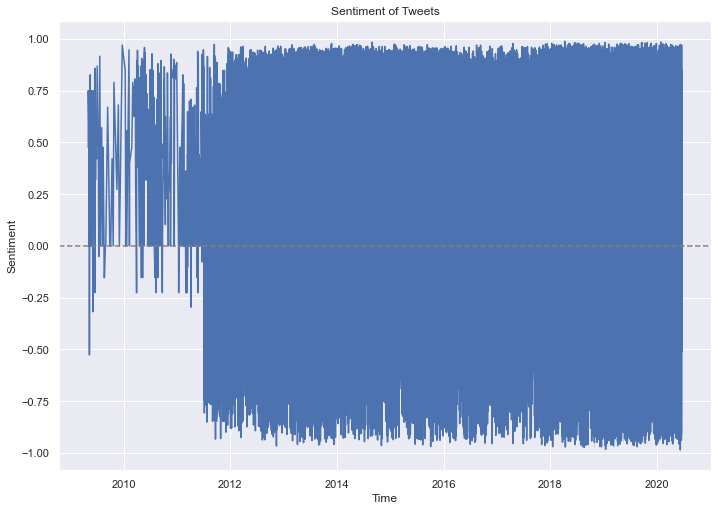

In [88]:
# Lineplot
g = sns.lineplot(x='date', y='compound', data=df)

#g.set(xticklabels=[]) 
g.set(title='Sentiment of Tweets')
g.set(xlabel="Time")
g.set(ylabel="Sentiment")
g.tick_params(bottom=False)

g.axhline(0, ls='--', c = 'grey')

<AxesSubplot:xlabel='sentiment', ylabel='compound'>

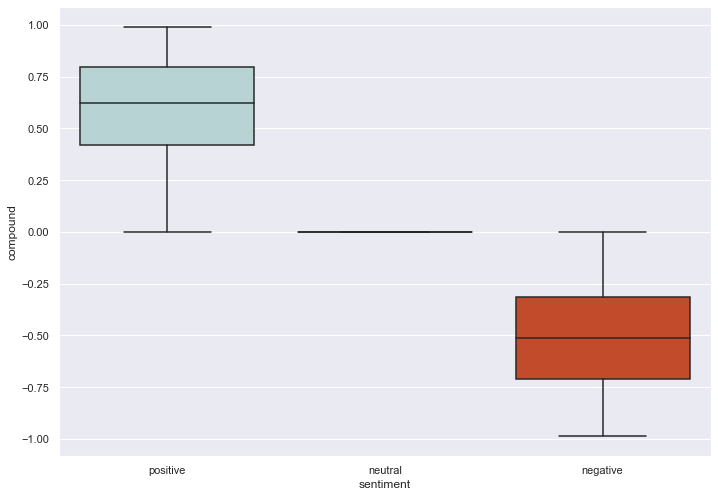

In [89]:
# Boxplot
sns.boxplot(y='compound', 
            x='sentiment',
            palette=['#b2d8d8',"#008080", '#db3d13'], 
            data=df)